#Machine Learning Final Project

In [516]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, train_test_split, GridSearchCV,cross_val_score,cross_validate
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, classification_report, f1_score,accuracy_score,confusion_matrix,mean_absolute_error
import seaborn as sns
%matplotlib inline

---
## Data Preprocessing

In [517]:
data = pd.read_csv("IMDB-Movie-Data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rank                1000 non-null   int64  
 1   Title               1000 non-null   object 
 2   Genre               1000 non-null   object 
 3   Description         1000 non-null   object 
 4   Director            1000 non-null   object 
 5   Actors              1000 non-null   object 
 6   Year                1000 non-null   int64  
 7   Runtime (Minutes)   1000 non-null   int64  
 8   Rating              1000 non-null   float64
 9   Votes               1000 non-null   int64  
 10  Revenue (Millions)  872 non-null    float64
 11  Metascore           936 non-null    float64
 12  quality             1000 non-null   object 
dtypes: float64(3), int64(4), object(6)
memory usage: 101.7+ KB


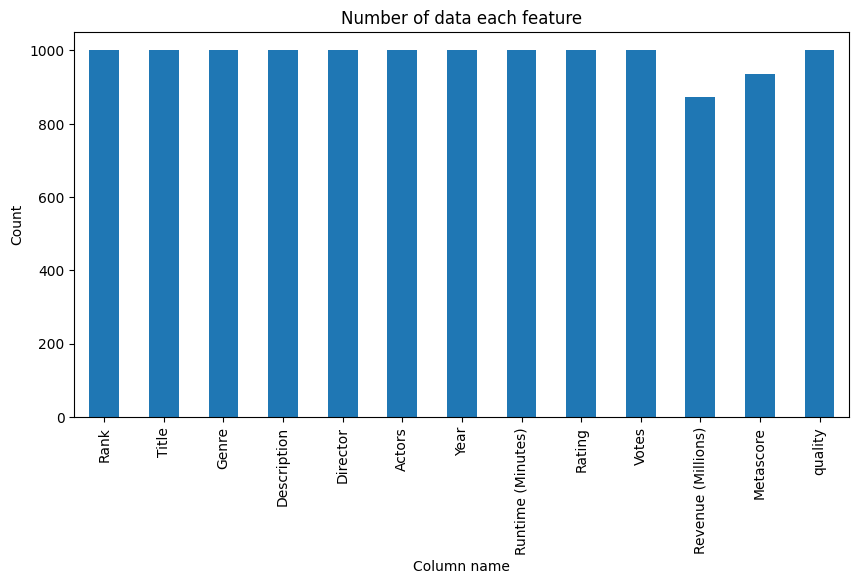

In [518]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("Number of data each feature")
ax.set_xlabel("Column name")
ax.set_ylabel("Count")
data.count().plot(kind='bar', ax=ax)
plt.show()

In [519]:
# Fill the null column
revenue_mean = data['Revenue (Millions)'].mean()
meta_mean = data['Metascore'].mean()
data['Revenue (Millions)'].fillna((revenue_mean), inplace=True)
data['Metascore'].fillna((revenue_mean), inplace=True)

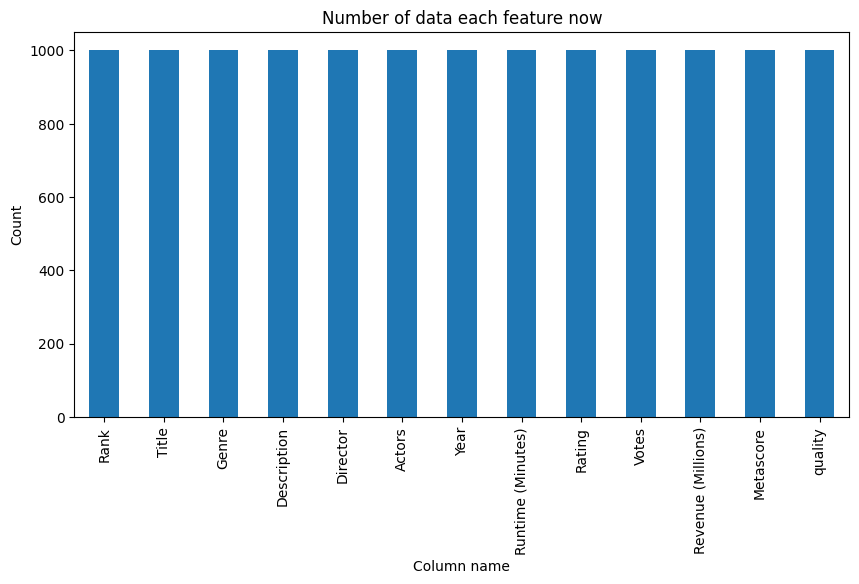

In [520]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("Number of data each feature now")
ax.set_xlabel("Column name")
ax.set_ylabel("Count")
data.count().plot(kind='bar', ax=ax)
plt.show()

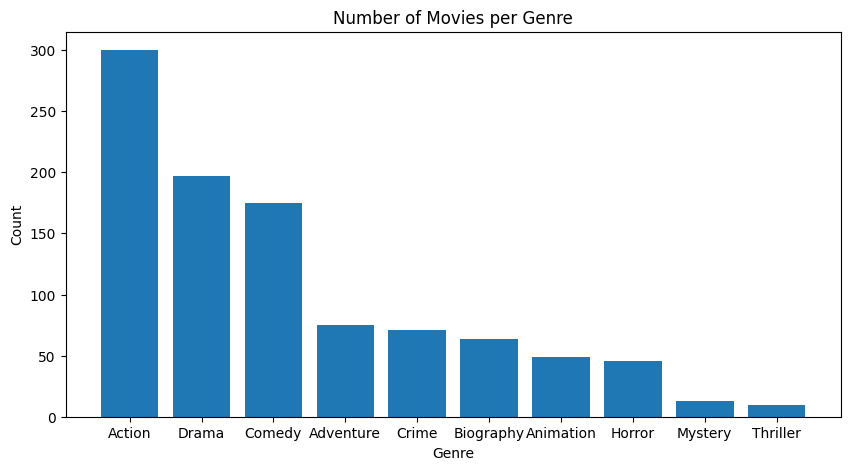

In [521]:
genre_counts = data['Genre'].value_counts()

# Create a bar plot to visualize the count of movies in each genre
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(genre_counts.index, genre_counts.values)
ax.set_title('Number of Movies per Genre')
ax.set_xlabel('Genre')
ax.set_ylabel('Count')
plt.show()

In [522]:
data['Genre'].unique()
data['Genre'] = data['Genre'].replace(['Ho', 'Mystery'], 'Horror')

In [523]:
id_Genre = LabelEncoder()
data['Genre'] = id_Genre.fit_transform(data['Genre']) 
data['Genre'].unique()

array([0, 1, 7, 2, 4, 3, 6, 5, 8])

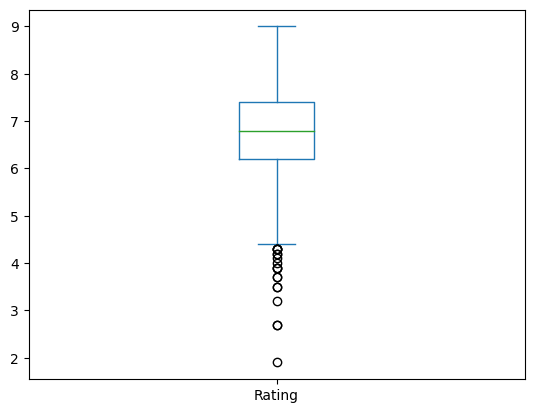

In [524]:
data['Rating'].describe()
data['Rating'].plot(kind="box");

In [525]:
X_cls = data.drop(["Title","Rank", "Description" , "Director" , "Actors", "Year" , "quality" ], axis=1)
y_cls = data["quality"]

X_reg = data.drop([ "Title" ,"Rank", "Description" , "Director" , "Actors", "Year" , "quality", "Rating" ], axis=1)
y_reg =data["Rating"]
X_reg.head()

,Genre,Runtime (Minutes),Votes,Revenue (Millions),Metascore
0,0,121,757074,333.13,76.0
1,1,124,485820,126.46,65.0
2,7,117,157606,138.12,62.0
3,2,108,60545,270.32,59.0
4,0,123,393727,325.02,40.0


In [526]:
#Normalize the data
scaler = StandardScaler()
X_norm_z = scaler.fit_transform(X_cls)
# Split the data into train and test sets
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_norm_z, y_cls, test_size=0.3, random_state=42)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg.values, y_reg.values, test_size=0.3, random_state=42)

In [527]:
df = pd.DataFrame(data=X_cls)
df.iloc[:, 0:6].head(6)

,Genre,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
0,0,121,8.1,757074,333.13,76.0
1,1,124,7.0,485820,126.46,65.0
2,7,117,7.3,157606,138.12,62.0
3,2,108,7.2,60545,270.32,59.0
4,0,123,6.2,393727,325.02,40.0
5,0,103,6.1,56036,45.13,42.0


In [528]:
# Standardize the Data and Perform the PCA
scaler.fit(df)
rate_scaled = scaler.transform(df)

In [529]:
pca = PCA(n_components=3)
pca.fit(rate_scaled)
pca_rate = pca.transform(rate_scaled)

In [530]:
# Create the 3D Plot of the PCA
Xax = pca_rate[:,0]
Yax = pca_rate[:,1]
Zax = pca_rate[:,2]

In [531]:
cdict = {0:'m',1:'c'}
label = {0:'Malignant',1:'Benign'}

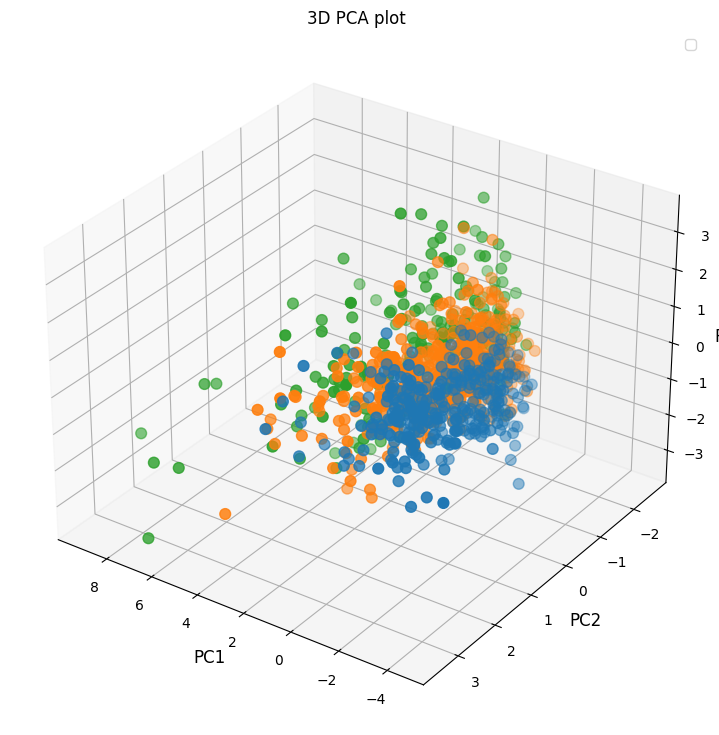

In [532]:
fig = plt.figure(figsize=(14,9))
ax = fig.add_subplot(111,projection='3d')
 
for l in np.unique(y_cls):
 ix=np.where(y_cls==l)
 ax.scatter(Xax[ix], 
            Yax[ix], 
            Zax[ix], 
            s=60)
 
ax.set_xlabel("PC1", 
              fontsize=12)
ax.set_ylabel("PC2", 
              fontsize=12)
ax.set_zlabel("PC3", 
              fontsize=12)
 
ax.view_init(30, 125)
ax.legend()
plt.title("3D PCA plot")
plt.show()

---
## Classification Model 

In [533]:

# Create a list of K values to test
k_values = list(range(1, 11))

# Create a KNN classifier object
knn = KNeighborsClassifier()

# Create a dictionary to store the results for each K
results = {'k': [], 'accuracy': [], 'f1_score': []}

# Loop over each K value and perform 5-fold cross-validation
for k in k_values:
    knn.set_params(n_neighbors=k) # set K value for the KNN model
    scores = cross_val_score(knn, X_train_cls, y_train_cls, cv=5) # perform 5-fold cross-validation
    avg_accuracy = scores.mean() # calculate average accuracy over 5 folds
    f1_scores = cross_val_score(knn, X_train_cls, y_train_cls, cv=5, scoring='f1_macro') # calculate F1 scores over 5 folds
    avg_f1_score = f1_scores.mean() # calculate average F1 score over 5 folds
    results['k'].append(k)
    results['accuracy'].append(avg_accuracy)
    results['f1_score'].append(avg_f1_score)

# Find the K value with the highest accuracy and f1 score
best_accuracy_index = results['accuracy'].index(max(results['accuracy']))
best_f1_score_index = results['f1_score'].index(max(results['f1_score']))
best_accuracy_k = results['k'][best_accuracy_index]
best_f1_score_k = results['k'][best_f1_score_index]
best_accuracy = results['accuracy'][best_accuracy_index]
best_f1_score = results['f1_score'][best_f1_score_index]

# Print the results
print("Best K for highest accuracy: {}".format(best_accuracy_k))
print("Highest accuracy: {:.2f}%".format(best_accuracy * 100))
print("Best K for highest F1 score: {}".format(best_f1_score_k))
print("Highest F1 score: {:.2f}%".format(best_f1_score * 100))

Best K for highest accuracy: 10
Highest accuracy: 85.86%
Best K for highest F1 score: 10
Highest F1 score: 85.44%


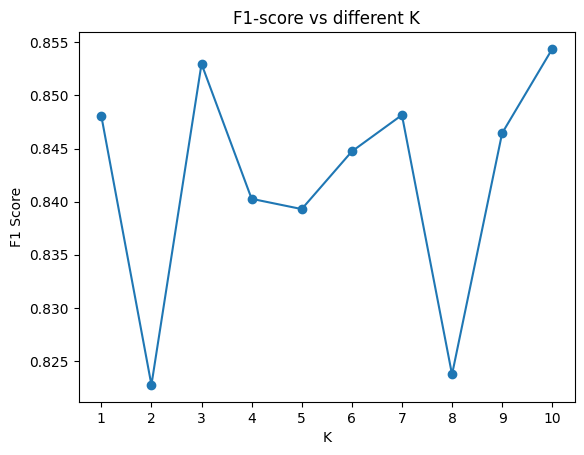

In [535]:
# Create a line plot of F1 scores for each K value
plt.plot(k_values, results['f1_score'], marker='o')
plt.title('F1-score vs different K')
plt.xlabel('K')
plt.ylabel('F1 Score')
plt.xticks(k_values)
plt.show()

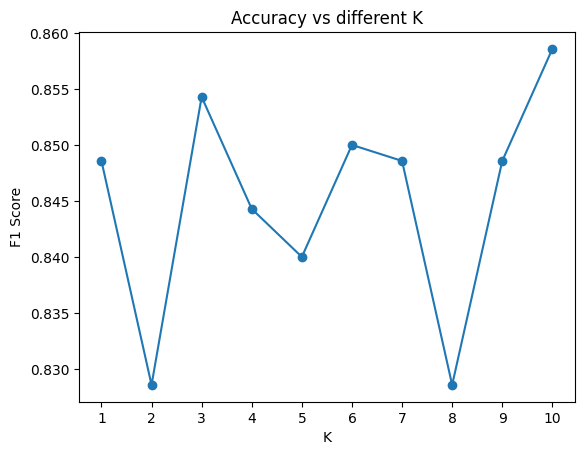

In [536]:
# Create a line plot of F1 scores for each K value
plt.plot(k_values, results['accuracy'], marker='o')
plt.title('Accuracy vs different K')
plt.xlabel('K')
plt.ylabel('F1 Score')
plt.xticks(k_values)
plt.show()

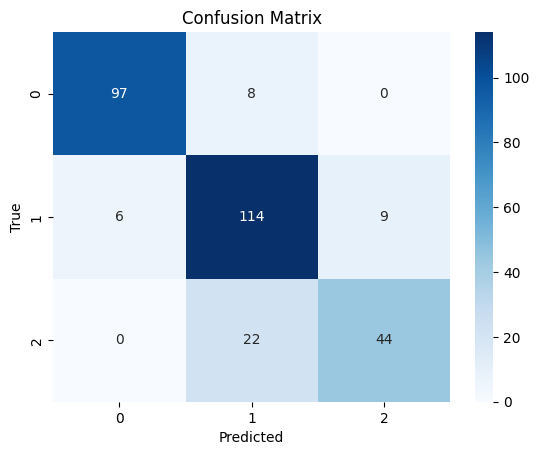

In [537]:
knn_best = KNeighborsClassifier(n_neighbors=10)

# Fit the classifier to the training data
knn.fit(X_train_cls, y_train_cls)

# Use the classifier to make predictions on the test data
y_pred_cls = knn.predict(X_test_cls)

# Create a confusion matrix using the predicted and true labels
cm = confusion_matrix(y_test_cls, y_pred_cls)

# Create a heatmap of the confusion matrix using the seaborn library
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Regression Model

### Decision Tree

In [538]:
def Evaluation(model, X_test, y_test):
    y_pred = model.predict(X_test)

    print(
        f"""Test error
        {model.__class__.__name__}:
        MAE = {mean_absolute_error(y_test, y_pred):.3f}
        MSE = {mean_squared_error(y_test, y_pred):.3f}
        R^2 = {model.score(X_test,y_test):.3f}
        """
    )

In [539]:
DecisionTree = DecisionTreeRegressor(random_state=42)

DecisionTree.fit(X_train_reg, y_train_reg)

Evaluation(DecisionTree, X_test_reg, y_test_reg)

Test error
        DecisionTreeRegressor:
        MAE = 0.695
        MSE = 0.862
        R^2 = 0.065
        


In [540]:
criterion = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
param_grid = {'criterion':criterion}

DecisionTree = GridSearchCV(DecisionTreeRegressor(random_state=42),
                            param_grid=param_grid,
                            n_jobs = -1)

best_DecisionTree = DecisionTree.fit(X_train_reg, y_train_reg)
print(DecisionTree.best_params_)

Evaluation(best_DecisionTree, X_test_reg, y_test_reg)

{'criterion': 'friedman_mse'}
Test error
        GridSearchCV:
        MAE = 0.701
        MSE = 0.838
        R^2 = 0.091
        


In [541]:
num_leafs = [5, 10, 50, 100]
param_grid = {'min_samples_leaf':num_leafs}

DecisionTree = GridSearchCV(DecisionTreeRegressor(random_state=42,
                                                  criterion = 'friedman_mse'),
                            param_grid=param_grid,
                            n_jobs = -1)

best_DecisionTree = DecisionTree.fit(X_train_reg, y_train_reg)
print(DecisionTree.best_params_)

Evaluation(best_DecisionTree, X_test_reg, y_test_reg)

{'min_samples_leaf': 10}
Test error
        GridSearchCV:
        MAE = 0.538
        MSE = 0.547
        R^2 = 0.407
        


In [542]:
depths = np.arange(1, 25)

param_grid = {'max_depth':depths}

DecisionTree = GridSearchCV(DecisionTreeRegressor(random_state=42,
                                                  criterion = 'friedman_mse',
                                                  min_samples_leaf = 10),
                            param_grid=param_grid,
                            n_jobs = -1)

best_DecisionTree = DecisionTree.fit(X_train_reg, y_train_reg)
print(DecisionTree.best_params_)

Evaluation(best_DecisionTree, X_test_reg, y_test_reg)

{'max_depth': 10}
Test error
        GridSearchCV:
        MAE = 0.538
        MSE = 0.547
        R^2 = 0.407
        


In [543]:
DecisionTree = DecisionTreeRegressor(random_state=42,
                                     criterion = 'friedman_mse',
                                     min_samples_leaf = 10)

best_DecisionTree = DecisionTree.fit(X_train_reg, y_train_reg)

Evaluation(best_DecisionTree, X_test_reg, y_test_reg)

Test error
        DecisionTreeRegressor:
        MAE = 0.538
        MSE = 0.547
        R^2 = 0.407
        


### Random Forest

In [544]:
RandomForest = RandomForestRegressor(random_state = 42)
RandomForest.fit(X_train_reg, y_train_reg)

Evaluation(RandomForest, X_test_reg, y_test_reg)

Test error
        RandomForestRegressor:
        MAE = 0.489
        MSE = 0.446
        R^2 = 0.516
        


In [545]:
n_estimators = [50, 100, 200, 500]
param_grid = {'n_estimators':n_estimators}

RandomForest = GridSearchCV(RandomForestRegressor(random_state = 42),
                            param_grid,
                            n_jobs = -1)
best_RandomForest = RandomForest.fit(X_train_reg,y_train_reg)
print(RandomForest.best_params_)

Evaluation(best_RandomForest, X_test_reg, y_test_reg)

{'n_estimators': 500}
Test error
        GridSearchCV:
        MAE = 0.488
        MSE = 0.443
        R^2 = 0.519
        


In [546]:
depths = np.arange(1, 21)
param_grid = {'max_depth':depths}

RandomForest = GridSearchCV(RandomForestRegressor(random_state = 42,
                                                  n_estimators = 500),
                            param_grid,
                            n_jobs = -1)
best_RandomForest = RandomForest.fit(X_train_reg,y_train_reg)
print(RandomForest.best_params_)

Evaluation(best_RandomForest, X_test_reg, y_test_reg)

{'max_depth': 6}
Test error
        GridSearchCV:
        MAE = 0.483
        MSE = 0.439
        R^2 = 0.524
        


In [547]:
num_leafs = [5, 10, 50, 100]
param_grid = {'min_samples_leaf':num_leafs}

RandomForest = GridSearchCV(RandomForestRegressor(random_state = 42,
                                                  n_estimators = 500,
                                                  max_depth = 6),
                            param_grid,
                            n_jobs = -1)
best_RandomForest = RandomForest.fit(X_train_reg,y_train_reg)
print(RandomForest.best_params_)

Evaluation(best_RandomForest, X_test_reg, y_test_reg)

{'min_samples_leaf': 5}
Test error
        GridSearchCV:
        MAE = 0.483
        MSE = 0.445
        R^2 = 0.517
        


In [548]:
RandomForest = RandomForestRegressor(random_state = 42,
                                     n_estimators = 500,
                                     max_depth = 6,
                                     min_samples_leaf = 5,
                                     n_jobs = -1)

best_RandomForest = RandomForest.fit(X_train_reg,y_train_reg)

Evaluation(best_RandomForest, X_test_reg, y_test_reg)

Test error
        RandomForestRegressor:
        MAE = 0.483
        MSE = 0.445
        R^2 = 0.517
        


### Model Evaluation

In [549]:
y_predDT = best_DecisionTree.predict(X_test_reg)
y_predRF = best_RandomForest.predict(X_test_reg)

pred_test = np.array([y_predDT,y_predRF,y_test_reg]).T
pd.DataFrame(pred_test,columns=['Decision Tree','Radom Forest','True Value']).head()

,Decision Tree,Radom Forest,True Value
0,6.823077,6.606272,5.3
1,6.950000,6.772958,7.1
2,6.073333,6.108748,5.4
3,7.120000,7.000417,7.0
4,6.685714,6.851472,6.5


In [550]:
predict = np.array([0,120,757000,333,75]).reshape(1,-1) # Close to Movie: Guardians of the Galaxy which have 8.1 IMDB Score

DT_pred = best_DecisionTree.predict(predict)
RF_pred = best_RandomForest.predict(predict)

pred = np.array([DT_pred,RF_pred,[8.1]]).T
pd.DataFrame(pred,columns=['Decision Tree','Radom Forest','True Value'])

,Decision Tree,Radom Forest,True Value
0,8.290909,8.112367,8.1


We can see that 2 models predict are pretty good. Therefore, even the error and R^2 score of Random Forest model is better than Decision Tree model so we will use Random Forest model

## Saving Model 

In [551]:
import pickle

In [552]:
data = {"model1": best_RandomForest , "model2" : knn_best, "id_Genre": id_Genre} 
with open("Save_model.pkl", 'wb' ) as file:
  pickle.dump(data,file)

In [553]:
with open("Save_model.pkl", 'rb' ) as file:
        data = pickle.load(file)